In [1]:
import numpy as np
from gym import Env
import seaborn as sns
import matplotlib.pylab as plt
import random

In [2]:

def make_map(studentNum, grid_size, pro_safe_road, randd): 
    """
    Observation Space : map of environment 
    A 6*6 Grid Graph
    Start point = (0,0)
    End point = (5,5)
    Just one safe path for each Student number
    The probability of falling in each state:
    in safe path = 0.0001 and for other states = 1

    :param 1: Student number 
    
    :return : The Created Map 
    """
    x_axis, y_axis = grid_size

    np.random.seed(studentNum)  
    move = np.zeros((x_axis-1)+(y_axis-1))  # Minimum moves for start to the end point in a 6*6 grid graph
    idx = np.random.choice(range((x_axis-1)+(y_axis-1)),size=int(((x_axis-1)+(y_axis-1))/2),replace=False)
    move[idx] = 1

    point = [0,0]
    lowprobs = [tuple(point)]
    for m in move:
        if m:
            point[0] += 1

        else:
            point[1] += 1
            
        lowprobs.append(tuple(point))

    idx = np.array(lowprobs)
    if randd :
        map = np.random.random(grid_size)
    else :
        map = np.ones(grid_size)
    map[idx[:,0],idx[:,1]] = pro_safe_road
    
    map[0,0] = 0.0   # Start point
    map[x_axis-1, y_axis-1] = 0.0   # End point

    return map, idx




c:\Program Files\Python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class FrozenLake(Env):
    def __init__(self, mapp, p_transition, r_goal):
        """
        Add whatever paramether you need :!

        - Student Number
        - action_space: All available actions the agent can perform.(LEFT = 0,DOWN = 1,RIGHT = 2,UP = 3)
        - observation_space: Structure of the observation.(map of environment)

        Dont forget to reset the environment :)

        """
       
        self.p_transition = p_transition
        self.r_transition = -1
        self.r_break = -10
        self.r_goal = r_goal
        self.grid = mapp
        self.stateSpace = [i for i in range(self.grid.shape[0]*self.grid.shape[1])]
        self.p_break_states = [i for idx,i in enumerate(self.grid.reshape(-1))]

        # LEFT = 0,DOWN = 1,RIGHT = 2,UP = 3
        self.possibleActions = [0, 1, 2 , 3]
        self.actionSpace = {0 : -1, 1 : self.grid.shape[0],
                            2 : 1 , 3 : -self.grid.shape[0]}
       

    def possibleNextStatesAndActions(self, state):
        statesAndActions = []

        for act in self.possibleActions :
            n_state = state + self.actionSpace[act]
        
            if n_state in self.stateSpace and self.offGridMove(n_state, state):
                statesAndActions.append((n_state, act))
            elif state not in statesAndActions:
                statesAndActions.append((state, act))

        return statesAndActions


    def offGridMove(self, newState, oldState):
            # if we're trying to wrap around to next row

            if oldState % self.grid.shape[0] == 0 and newState  % self.grid.shape[0] == self.grid.shape[0] - 1:
                return False
            elif oldState % self.grid.shape[0] == self.grid.shape[0] - 1 and newState % self.grid.shape[0] == 0:
                return False
            else:
                return True

    
    def getReward(self, state):

            
        if state == self.stateSpace[-1]:
            return self.r_goal

        else:
            return self.r_transition
        



    def Transitions(self, state, action):
        transitions = []
        count_nextStates = len(self.possibleNextStatesAndActions(state)) 

        
        for n_s, act in self.possibleNextStatesAndActions(state):

            if act == action:
              transitions.append((self.p_transition, n_s ))

            else:
              
              transitions.append((round((1-self.p_transition)/(count_nextStates-1),2), n_s))
              
        if state == self.stateSpace[-1]:
            transitions = [(0, state)]

        if self.p_break_states[state] == 1:
            transitions = [(0, state)] 


        return transitions




## value_iteration

In [4]:
def value_iteration(env, num_states, num_actions, gamma, teta):
    
    value_function = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    error = np.inf

    while error > teta:
        new_value_function = np.zeros(num_states)
        for state in range(num_states):
            Qs = np.zeros(num_actions)
            for action in range(num_actions):
                transitions = env.Transitions(state, action)
                for transition in transitions:
                    p_Transition, nextS  = transition
                    Qs[action] += p_Transition *((env.p_break_states[nextS] * (env.r_transition + env.r_break)) + ((1-env.p_break_states[nextS])*(env.getReward(nextS) +(gamma*value_function[nextS]))))

            new_value_function[state] = max(Qs)

        diff_vf = new_value_function-value_function   
        value_function = new_value_function
        error = np.max(diff_vf)
        

    for state in range(num_states):
            Qs = np.zeros(num_actions)
            for action in range(num_actions):
                transitions = env.Transitions(state, action)
                for transition in transitions:
                    p_Transition, nextS  = transition
                    Qs[action] += p_Transition *((env.p_break_states[nextS] * (env.r_transition + env.r_break)) + ((1-env.p_break_states[nextS])*(env.getReward(nextS) +(gamma*value_function[nextS]))))
            
            max_index = np.where(Qs == np.max(Qs))
            policy[state] = max_index[0][0]
            
    return value_function, policy


In [5]:
def run_value_iteration(grid_size, pro_safe_road, randd, p_transition, r_goal, teta):

    m, safe_road_idx = make_map(810199296, grid_size, pro_safe_road, randd)
    env = FrozenLake(m, p_transition, r_goal)
    num_states = len(env.stateSpace)
    num_actions = len(env.actionSpace)
    value_function, policy = value_iteration(env, num_states, num_actions, 0.9, teta)

    return value_function, policy, m, safe_road_idx


## policy_iteration

In [6]:
def policy_evaluation(num_states, env, policy, value_function,  gamma, teta):
    
    #value_function = np.zeros(num_states)
    error = np.inf
    while error > teta :
        new_value_function = np.zeros(num_states)
        for state in range(num_states):
            a = policy[state]
            transitions = env.Transitions(state, a)
            for transition in transitions:
                p_Transition, nextS  = transition
                new_value_function[state] += p_Transition *((env.p_break_states[nextS] * (env.r_transition + env.r_break)) + ((1-env.p_break_states[nextS])*(env.getReward(nextS) +(gamma*value_function[nextS]))))
        
        error = np.max(new_value_function - value_function) 
        value_function = new_value_function    

    return value_function

In [7]:
def policy_improvement(num_states, num_actions, env, value_from_policy, policy, gamma):
    
    new_policy = np.zeros(num_states, dtype='int')
    policy_stable = True

    for state in range(num_states):
        Qs = np.zeros(num_actions)
        for action in range(num_actions):
            transitions = env.Transitions(state, action)
            for transition in transitions:
                p_Transition, nextS  = transition
                Qs[action] += p_Transition *((env.p_break_states[nextS] * (env.r_transition + env.r_break)) + ((1-env.p_break_states[nextS])*(env.getReward(nextS) +(gamma*value_from_policy[nextS]))))
            
        max_index = np.where(Qs == np.max(Qs))
        new_policy[state] = max_index[0][0]
    
    
    if (policy == new_policy).all() :
        policy_stable = False  

    return new_policy, policy_stable
    

In [8]:
def run_policy_iteration(grid_size, pro_safe_road, randd, p_transition, r_goal, teta):

    m,_ = make_map(810199296, grid_size, pro_safe_road, randd)
    env = FrozenLake(m, p_transition, r_goal)
    num_states = len(env.stateSpace)
    num_actions = len(env.actionSpace)
    value_function = np.zeros(num_states)
    policy = 0*np.ones(num_states, dtype=int)
    flag = True

    while flag:
        
        new_value_function = policy_evaluation(num_states, env, policy, value_function,  0.9, teta)
        new_policy, flag = policy_improvement(num_states,num_actions, env, new_value_function, policy, 0.9)
        value_function = new_value_function
        policy = new_policy

    return value_function, policy


In [9]:
def plot_value(value, grid_size, f_s):
    fig, ax = plt.subplots(figsize=f_s)

    sns.heatmap(value.reshape(grid_size), linewidth=0.5, annot=True)
    plt.show()


def plot_policy(policy, grid_size, safe_road_index, f_s):

    arrows = {2:(1,0), 0:(-1,0), 3:(0,1), 1:(0,-1)}
    scale = 0.25
    
    p = policy.reshape(grid_size)

    fig, ax = plt.subplots(figsize=f_s)
    for r, row in enumerate(p):
        for c, cell in enumerate(row):

            if r == len(p)-1 and c == len(p)-1 :
                break

            elif [r,c] in safe_road_index.tolist():
                plt.arrow(c, 5-r, scale*arrows[cell][0], scale*arrows[cell][1], head_width=0.1, color = 'red')

            else:
                plt.arrow(c, 5-r, scale*arrows[cell][0], scale*arrows[cell][1], head_width=0.1, color = 'black')
        
        

## part 1

In [12]:
v_valueIteration, p_valueIiteration, ma, safe_road_index = run_value_iteration(grid_size =(6,6), pro_safe_road = 0.0001, randd = False, p_transition = 0.94, r_goal = 100, teta = 0.001)

In [13]:
v_policyIiteration, p_policyIiteration = run_policy_iteration(grid_size = (6,6), pro_safe_road = 0.0001, randd = False, p_transition = 0.94, r_goal = 100, teta = 0.001)

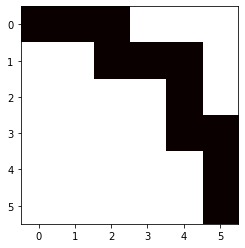

In [14]:
plt.imshow(ma, cmap='hot')
plt.show()

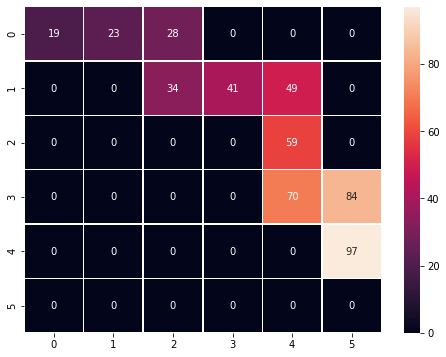

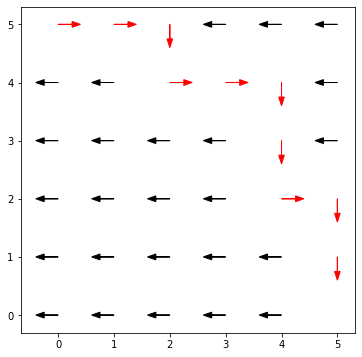

In [15]:
plot_value(v_policyIiteration, (6,6), (8,6))
plot_policy(p_policyIiteration, (6,6),safe_road_index, (6,6))

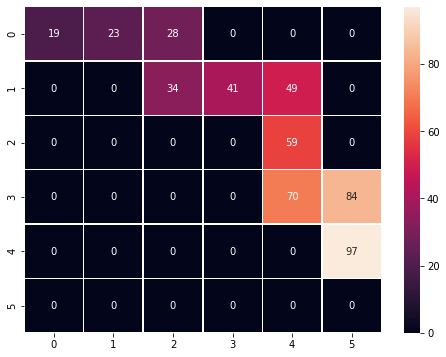

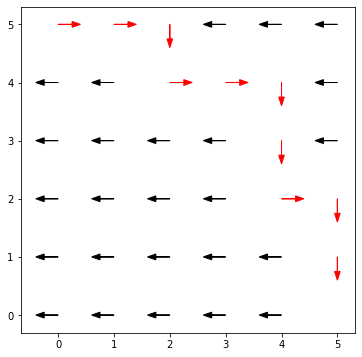

In [16]:
plot_value(v_valueIteration, (6,6), (8,6))
plot_policy(p_valueIiteration, (6,6),safe_road_index, (6,6))

## part 2

In [17]:
v_valueIteration, p_valueIiteration, ma, safe_road_index = run_value_iteration(grid_size =(6,6), pro_safe_road = 0.001, randd = True, p_transition = 0.7, r_goal = 100, teta = 0.001)

In [18]:
v_policyIiteration, p_policyIiteration = run_policy_iteration(grid_size = (6,6), pro_safe_road = 0.001, randd = True, p_transition = 0.7, r_goal = 100, teta = 0.001)

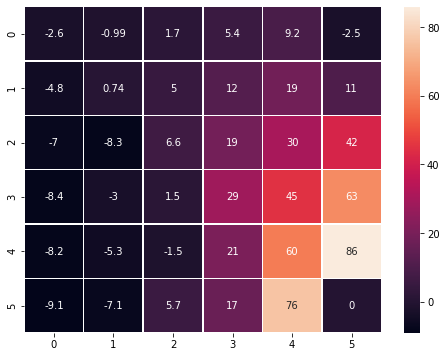

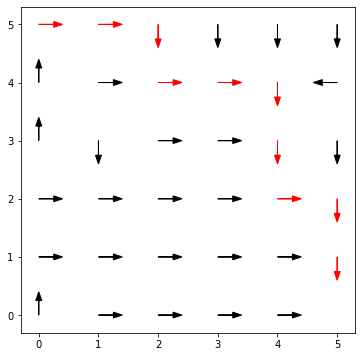

In [19]:
plot_value(v_policyIiteration, (6,6), (8,6))
plot_policy(p_policyIiteration, (6,6),safe_road_index, (6,6))

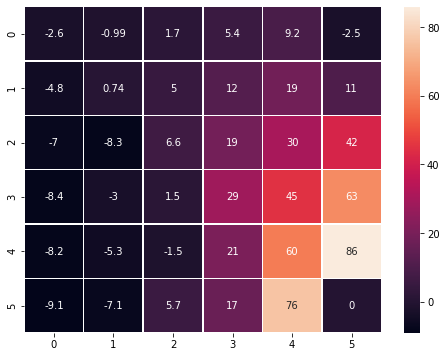

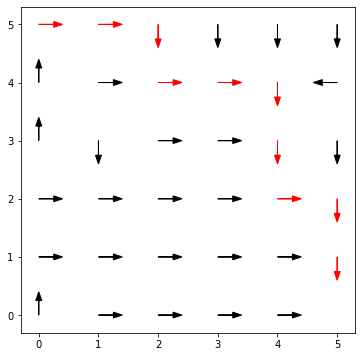

In [20]:
plot_value(v_valueIteration, (6,6), (8,6))
plot_policy(p_valueIiteration, (6,6), safe_road_index, (6,6))

## part 3

### الف

#### teta = 40

In [21]:
v_valueIteration, p_valueIiteration, ma, safe_road_index = run_value_iteration(grid_size =(15,15), pro_safe_road = 0.001, randd = True, p_transition = 0.7, r_goal = 100, teta = 40)

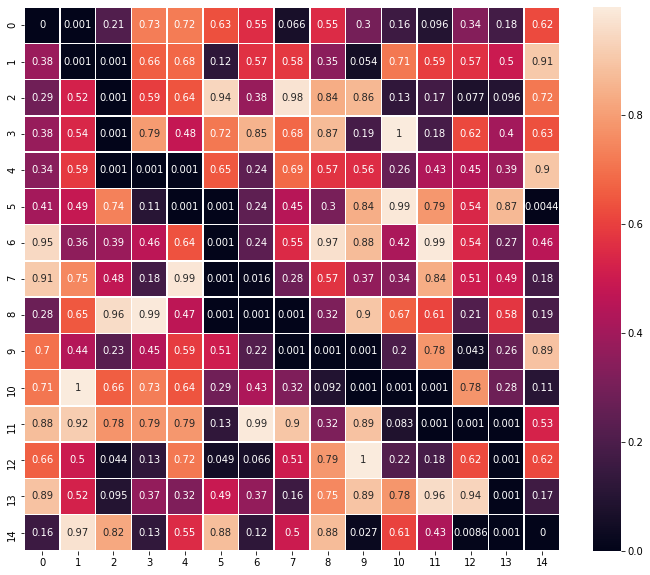

In [22]:
plt.subplots(figsize=(12,10))
sns.heatmap(ma, linewidth=0.5, annot=True)
#plt.imshow(ma, cmap='hot')
plt.show()

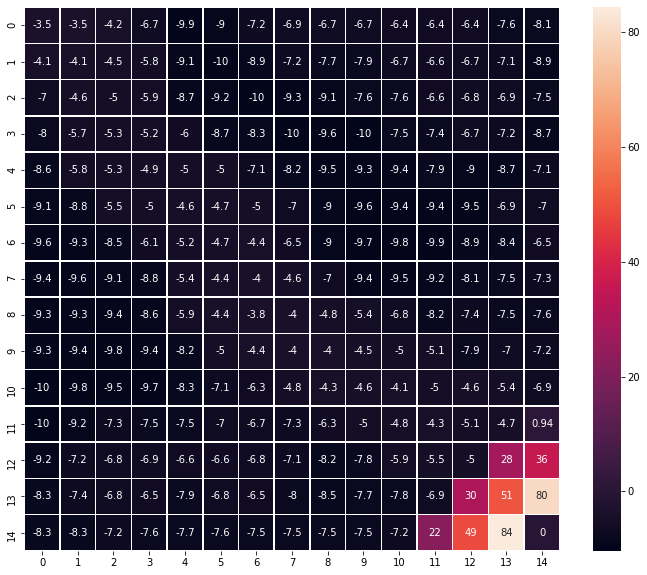

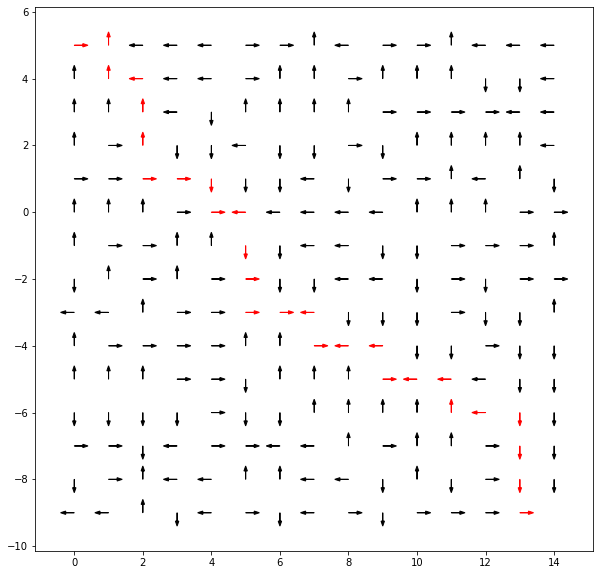

In [23]:
plot_value(v_valueIteration, (15,15), (12,10) )
plot_policy(p_valueIiteration, (15,15), safe_road_index, (10,10))

#### teta = 1

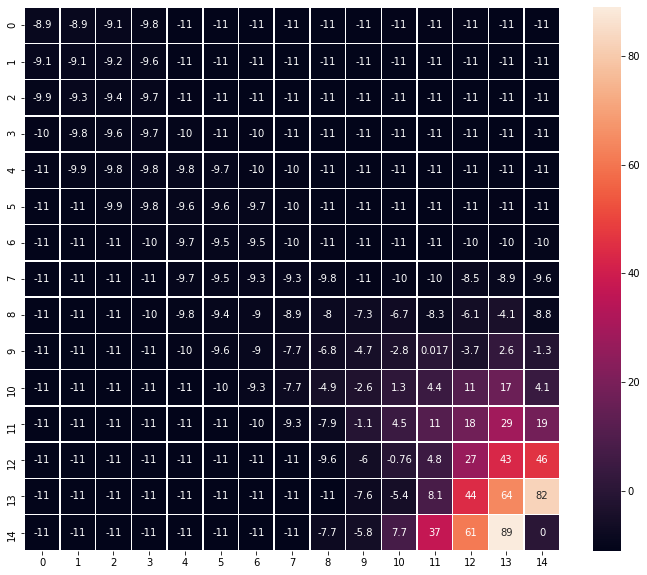

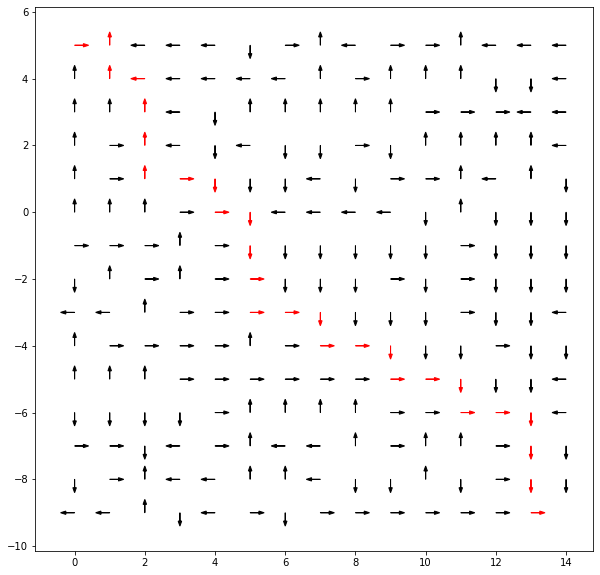

In [24]:
v_valueIteration, p_valueIiteration, ma, safe_road_index = run_value_iteration(grid_size =(15,15), pro_safe_road = 0.001, randd = True, p_transition = 0.7, r_goal = 100, teta = 1)
plot_value(v_valueIteration, (15,15), (12,10) )
plot_policy(p_valueIiteration, (15,15), safe_road_index, (10,10))

#### teta = 0.000001

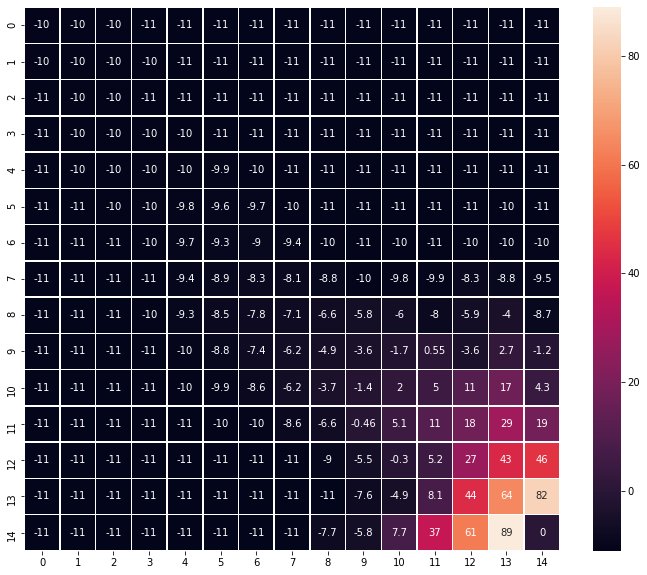

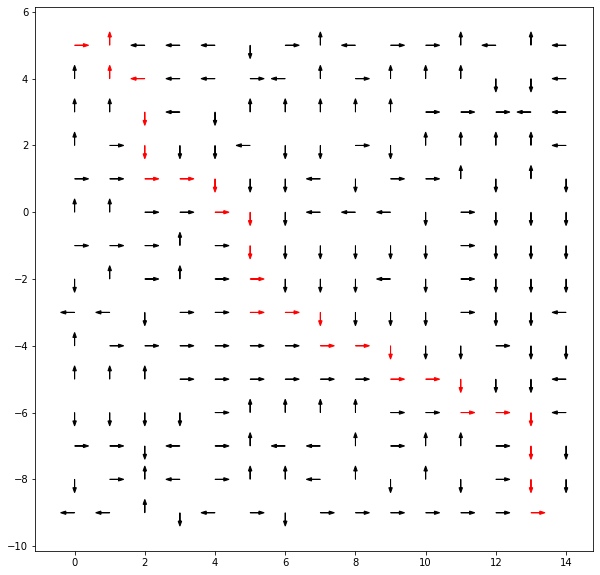

In [25]:
v_valueIteration, p_valueIiteration, ma, safe_road_index = run_value_iteration(grid_size =(15,15), pro_safe_road = 0.001, randd = True, p_transition = 0.7, r_goal = 100, teta = 0.000001)
plot_value(v_valueIteration, (15,15), (12,10) )
plot_policy(p_valueIiteration, (15,15), safe_road_index, (10,10))

### ب

#### reward = 500 , teta = 0.000001

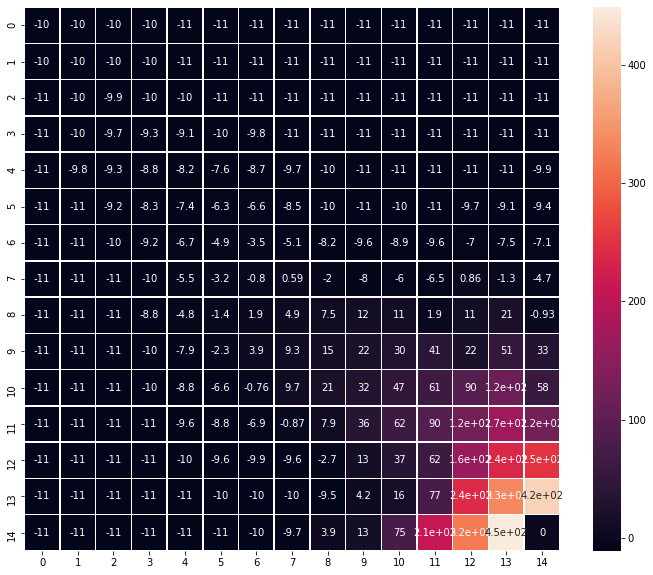

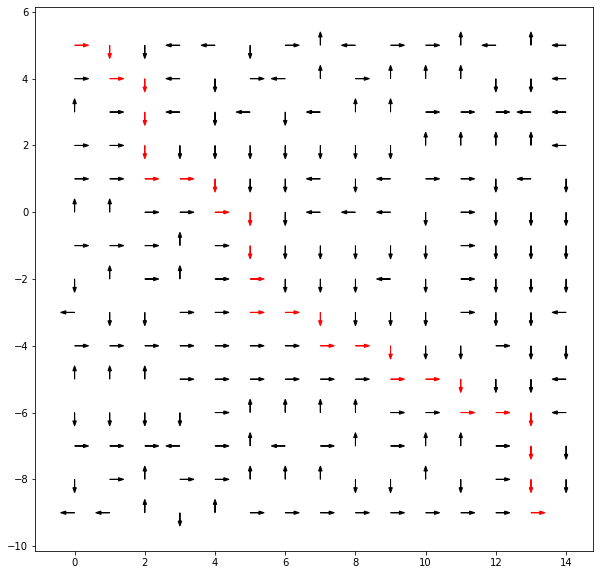

In [26]:
v_valueIteration, p_valueIiteration, ma, safe_road_index = run_value_iteration(grid_size =(15,15), pro_safe_road = 0.001, randd = True, p_transition = 0.7, r_goal = 500, teta = 0.000001)
plot_value(v_valueIteration, (15,15), (12,10) )
plot_policy(p_valueIiteration, (15,15), safe_road_index, (10,10))